In [5]:
import gym
import numpy as np
from gym import spaces
from stable_baselines3 import PPO
import shap
from mlutils import *
from tqdm import tqdm

加载标准化数据和scaler模型


In [6]:
# 配置类
class Config:
    # 目标性能阈值（根据需求修改）
    TARGETS = np.array([134, 278, 22.5])  # 三个性能指标的最低要求
    # SHAP参数
    SAMPLE_RATIO = 0.1     # 背景数据采样比例
    N_SUMMARY = 100        # SHAP背景数据压缩量
    TOP_K = 5              # 每个样本选择的关键参数数量

    MAX_STEPS = 100  # 最大步数
    BUFFER_RATIO = 0.1  # 动态范围比例

In [7]:
# 识别不合格样本
def find_unqualified_samples(y,  tragets):
    """找到至少有一个性能指标不达标的样本"""
    unqualified_mask = np.any(y < tragets, axis=1)
    return np.where(unqualified_mask)[0]

# 判断力学性能是否达标（用户自定义）
def is_satisfied(y_pred,  tragets):
    # 示例：假设 y_pred 是 3 个力学性能值，targets 是达标指标
    return all(y >= t for y, t in zip(y_pred, tragets))

#反标准化函数
def inverse_normalize(sample,scaler):
    inverse_sample=scaler.inverse_transform(sample.reshape(1,-1))
    return inverse_sample[0]
    

In [8]:
Procedure_header=['化学元素含量', '化学元素含量', '化学元素含量', '化学元素含量', '化学元素含量', '化学元素含量', '化学元素含量', '化学元素含量', '化学元素含量', 
                  '热轧', '热轧', '热轧', '热轧', '热轧', '热轧', '热轧', '热轧', 
                  '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', 
                  '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', 
                  '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧', '冷轧',
                  '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌', '镀锌']
Parameter_header = [
    "碳", "硅", "锰", "磷", "硫", "钛", "铌", "氧", "氮", "材料实际重量", "出口材料实际厚度",
    "出口材料实际宽度", "卷取温度平均值", "出炉温度", "在炉时间", "精轧入口平均温度", "精轧出口平均温度",
    "出口材料实际厚度公差", "出口材料实际宽度公差", "出口材料实际重量", "入口材料1厚度", "入口材料1宽度",
    "入口材料1重量", "S1机架压下率", "S2机架压下率", "S3机架压下率", "S4机架压下率", "S5机架压下率",
    "S1机架入口张力", "S1~S2机架间张力", "S2～S3机架间张力", "S3～S4机架间张力", "S4～S5机架间张力",
    "S5出口张力", "S1机架入口单位张力", "S1~S2机架间单位张力", "S2~S3机架间单位张力",
    "S3~S4机架间单位张力", "S4~S5机架间单位张力", "S5机架工作轧辊粗糙度(底)", "S5机架工作轧辊粗糙度(上)",
    "1#机架轧制力模型设定值", "2#机架轧制力模型设定值", "3#机架轧制力模型设定值", "4#机架轧制力模型设定值",
    "5#机架轧制力模型设定值", "拉矫率平均值", "1#酸槽温度", "2#酸槽温度", "3#酸槽温度", "酸洗工序速度平均值1",
    "上表面镀层重量", "下表面镀层重量", "平整率平均值", "上表面涂油量", "下表面涂油量", "工艺段速度平均值",
    "ES平均温度", "FCS平均温度", "IHS平均温度", "SCS平均温度", "SF平均温度", "RCS平均温度",
    "RTF平均温度", "JPF平均温度"
]


In [9]:
test_x,test_y=x_y_split(test_data_path, scaler=joblib.load(scaler_model_path))
train_x,train_y=x_y_split(train_data_path, scaler=joblib.load(scaler_model_path))

In [10]:
model_name='Random Forest'
model=models[model_name]
model=joblib.load(pre_model_path + model_name + '.pkl')

In [11]:
#随机提取train_x的0.1倍样本
train_x_sample=train_x[np.random.choice(train_x.shape[0], int(train_x.shape[0]*0.1), replace=False)]
train_x_sample_summary = shap.sample(train_x_sample, 100)
#使用shap的kernel explainer对混合模型
explainer = shap.KernelExplainer(model.predict, train_x_sample_summary)
def cal_shap_values(x):
    return explainer.shap_values(x)

In [12]:
def generate_param_bounds(sample, X_data, top_indices, buffer_ratio):
    """
    作用：根据历史数据和当前样本生成优化参数范围
    sample: 当前样本
    X_data: 历史数据
    top_indices: 优化参数索引
    buffer——ratio: 动态范围比例
    """
    bounds = {}
    for idx in top_indices:
        # 全局数据范围（考虑工艺限制）
        global_min = X_data[:, idx].min()
        global_max = X_data[:, idx].max()
        
        # 当前值
        current_val = sample[idx]
        
        # 动态范围：当前值±buffer_ratio范围的全局裁剪
        buffer_range = (global_max - global_min) * buffer_ratio
        min_val = max(global_min, current_val - buffer_range)
        max_val = min(global_max, current_val + buffer_range)
        
        bounds[f'x{idx}'] = (min_val, max_val)
    return bounds

131.0


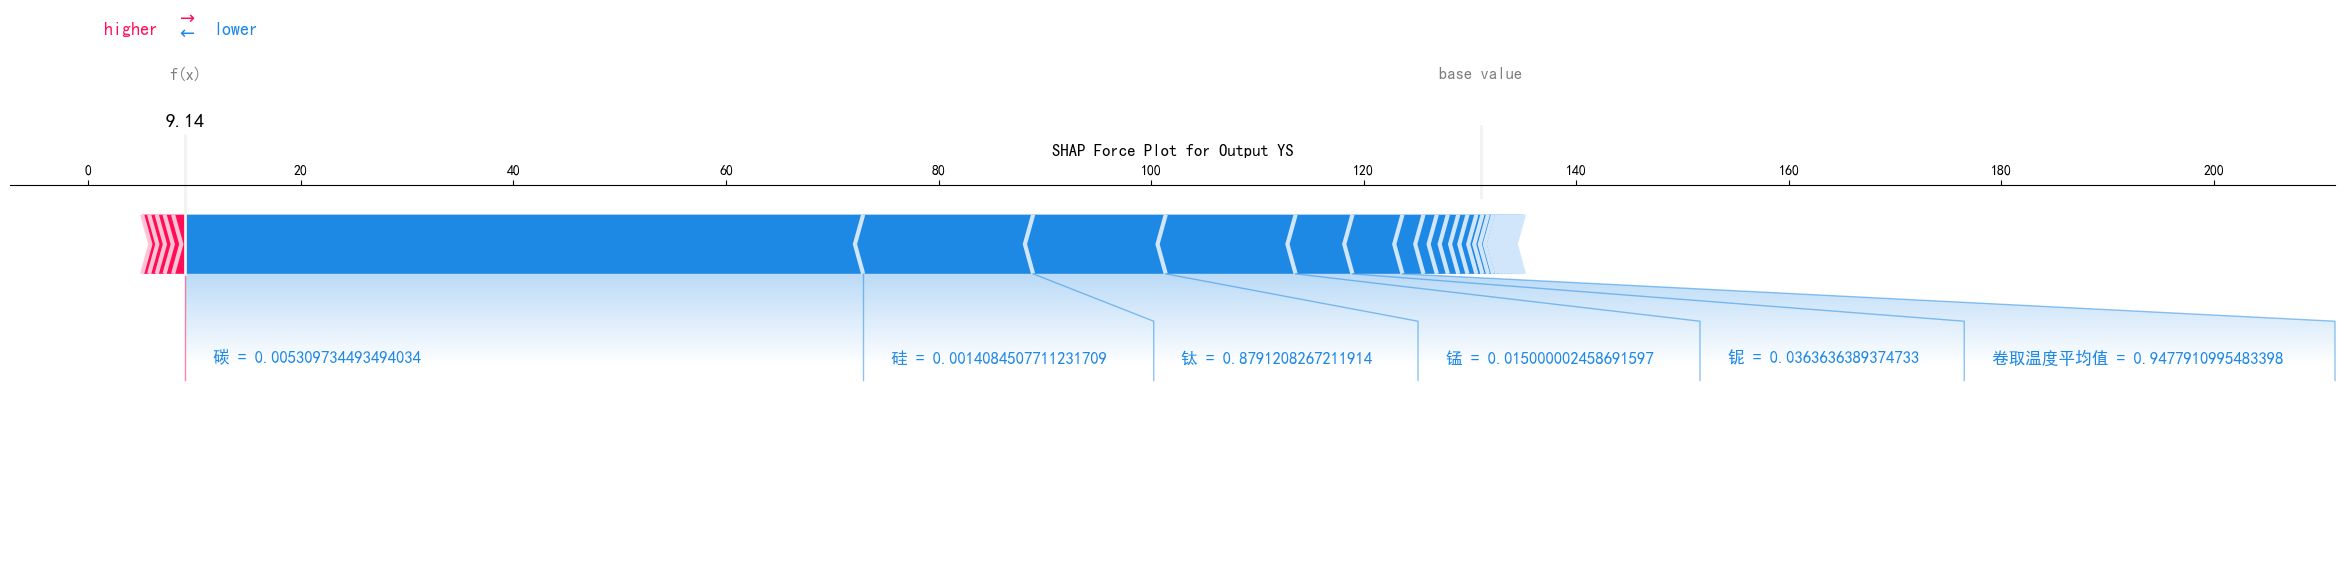

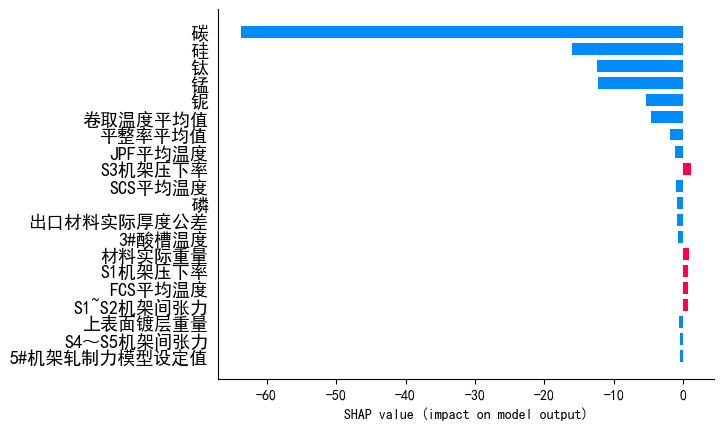

280.0


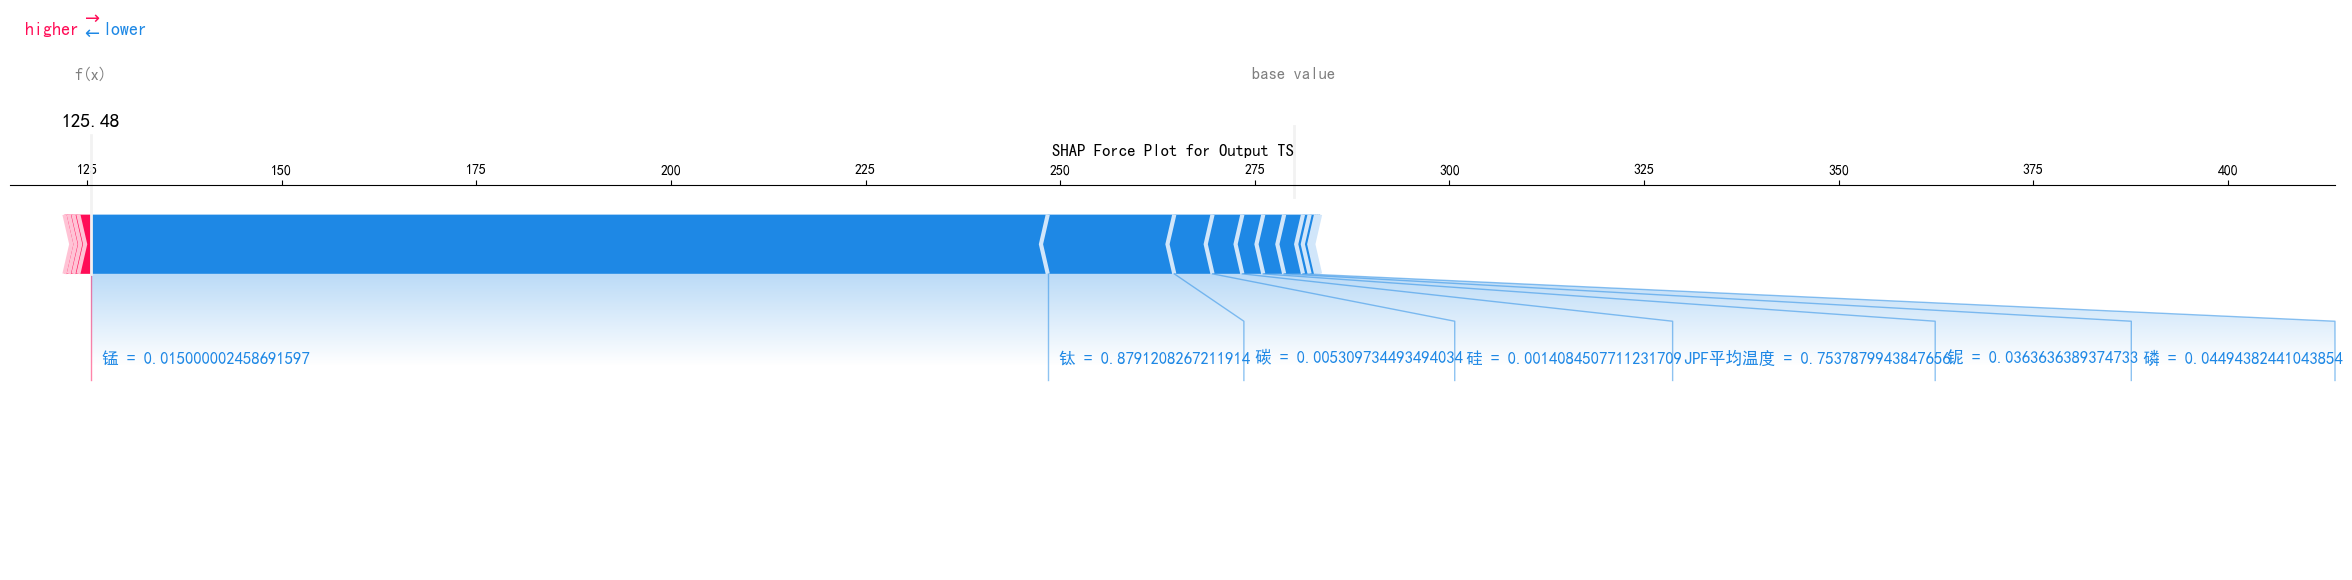

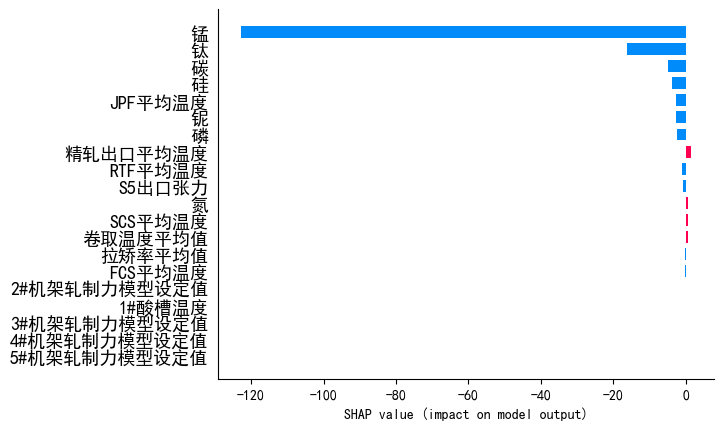

47.5


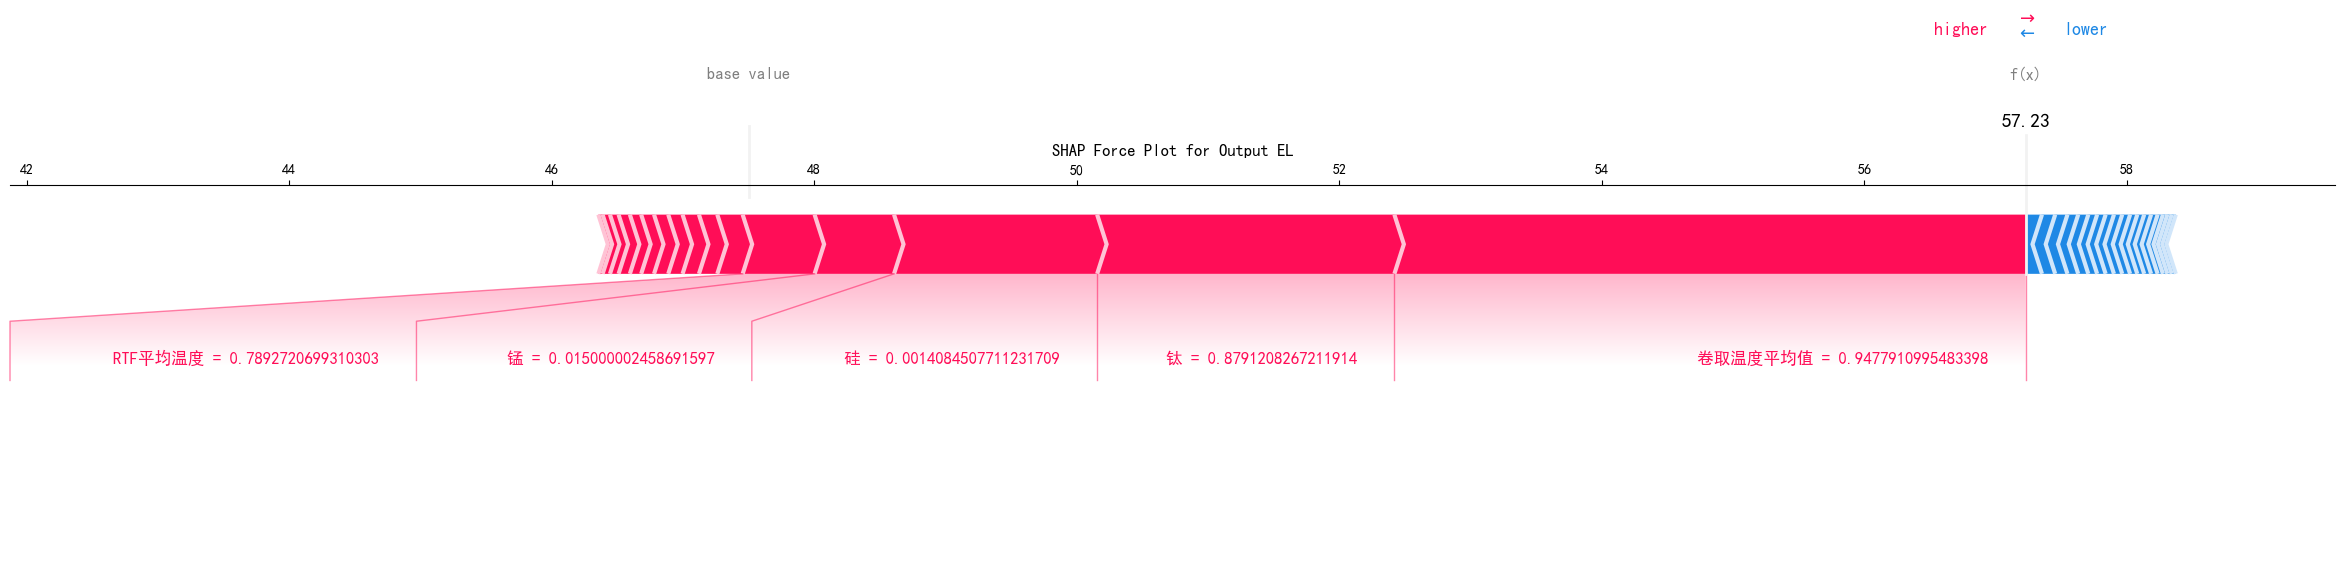

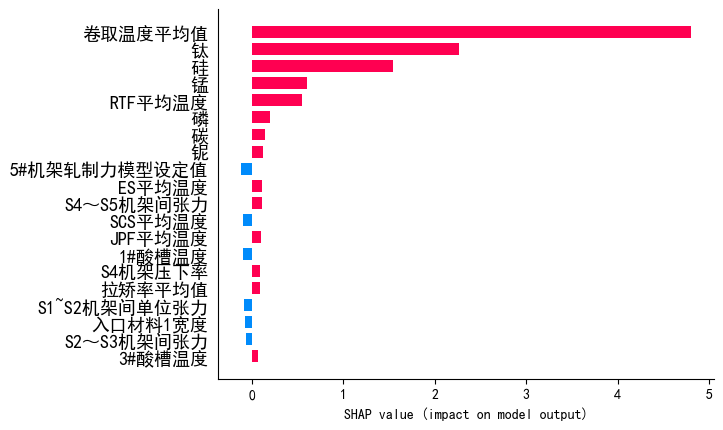

In [13]:
import shap
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号
# 选择样本
sample_idx = 27
sample = test_x[sample_idx] 

# 计算 SHAP 值
shap_values = cal_shap_values(sample)  # 形状为 (65, 3)

# 检查 SHAP 值形状
assert shap_values.shape == (65, 3), "SHAP 值形状不正确，应为 (65, 3)"

output_name=["YS","TS","EL"]
# 为每个输出生成 SHAP 可视化图
for output_idx in range(3):
    # 提取当前输出的 SHAP 值
    shap_values_output = shap_values[:, output_idx]  # 形状为 (65,)
    # print(shap_values_output)



    # 1. Force Plot
  
    base_value_output = test_y[sample_idx, output_idx]
    print(base_value_output)
    shap.force_plot(
        base_value_output,             # 基准值
        shap_values_output,            # 当前输出的 SHAP 值
        sample,                        # 样本的特征值
        feature_names=Parameter_header if 'Parameter_header' in globals() else None,  # 特征名称
        matplotlib=True,               # 使用 matplotlib 渲染
        show=False                     # 不直接显示，交给 plt.show() 处理
    )
#显示的更长
    plt.gcf().set_size_inches(30, 5)
    plt.title("SHAP Force Plot for Output " + output_name[output_idx])
    plt.show()

    # 2. Bar Plot
    shap.bar_plot(
        shap_values_output,            # 当前输出的 SHAP 值
        feature_names=Parameter_header if 'Parameter_header' in globals() else None,  # 特征名称
        max_display=20               
    )


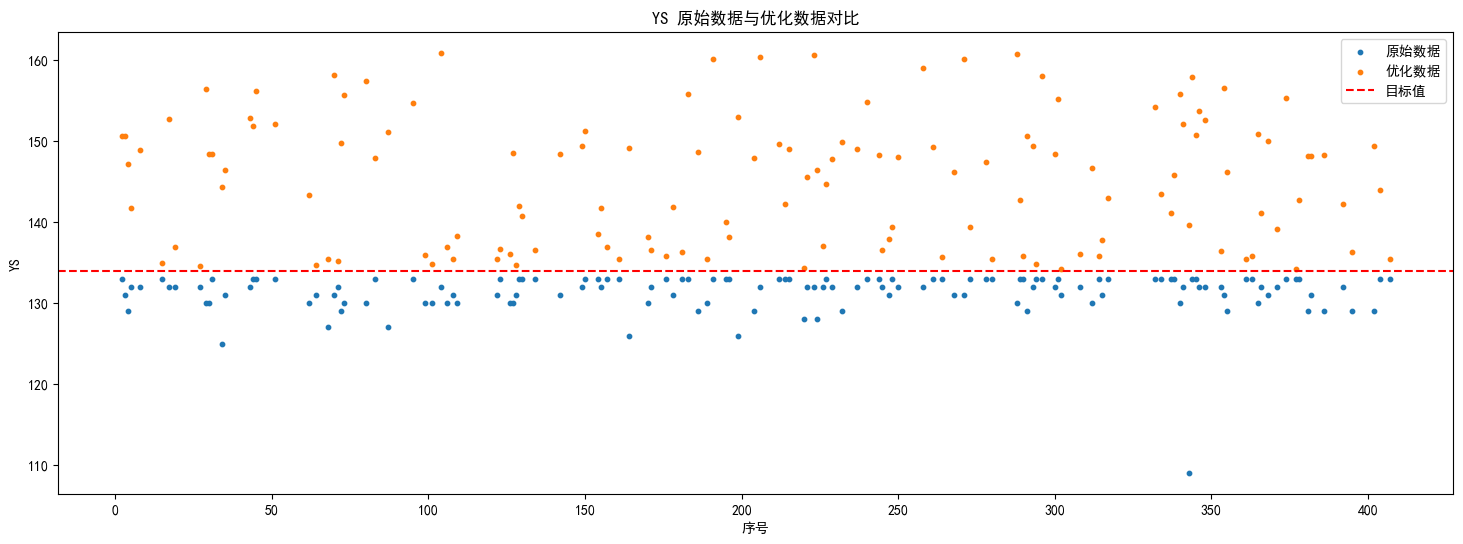

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# 读取数据，并选取指定列
results = pd.read_csv('results_PPO.csv')
results = results.iloc[:, 2:4]

# 使用 apply 对每行进行检查，如果第二列为空（NaN 或空字符串），则用第一列的数据替换
results.iloc[:, 1] = results.apply(lambda row: row[0] if pd.isnull(row[1]) or row[1] == '' else row[1], axis=1)

def str_to_list(s):
    # 如果字符串中包含逗号，则直接用 ast.literal_eval 处理
    if ',' in s:
        num_list = ast.literal_eval(s)
    else:
        # 去掉两边的中括号，并按空白字符分割
        s_clean = s.strip("[]")
        # 利用 split() 分割字符串（会自动处理多空格）
        str_nums = s_clean.split()
        num_list = [float(num) for num in str_nums]
    # 对列表中的每个数字保留一位小数
    return [round(num, 1) for num in num_list]

# 对 DataFrame 中所有元素应用转换函数
results = results.applymap(str_to_list)


#ori_YS是所有第一列的数据的第一个元素
ori_YS = results.iloc[:, 0].apply(lambda x: x[0])
ori_TS = results.iloc[:, 0].apply(lambda x: x[1])
ori_EL = results.iloc[:, 0].apply(lambda x: x[2])

opt_YS = results.iloc[:, 1].apply(lambda x: x[0])
opt_TS = results.iloc[:, 1].apply(lambda x: x[1])
opt_EL = results.iloc[:, 1].apply(lambda x: x[2])

goal=[134, 278, 22.5]


# 识别YS不合格样本
filtered_indices = [i for i in range(len(ori_YS)) if ori_YS[i] < goal[0]]
filtered_ori_YS = [ori_YS[i] for i in filtered_indices]
filtered_opt_YS = [opt_YS[i] for i in filtered_indices]

# 绘制散点图
plt.figure(figsize=(18, 6))
plt.scatter(filtered_indices, filtered_ori_YS, label='原始数据', s=10)
plt.scatter(filtered_indices, filtered_opt_YS, label='优化数据', s=10)

# 绘制目标值的虚线
plt.axhline(y=goal[0], color='r', linestyle='--', label='目标值')

# 添加标签和标题
plt.xlabel('序号')
plt.ylabel('YS')
plt.legend()
plt.title('YS 原始数据与优化数据对比')

# 显示图像
plt.show()


# # 用散点图原始数据和优化数据ys的对比图,横坐标是序号，纵坐标是YS的值，只绘制原始样本中低于目标值的样本
# plt.figure(figsize=(18, 6))
# # 绘制散点图，s参数设置点的大小（例如设置为10）
# plt.scatter(range(len(ori_YS)), ori_YS, label='原始数据', s=10)
# plt.scatter(range(len(opt_YS)), opt_YS, label='优化数据', s=10)

# # 绘制目标值的虚线
# plt.plot([0, len(ori_YS)], [goal[0], goal[0]], 'r--', label='目标值')

# # 添加标签和标题
# plt.xlabel('序号')
# plt.ylabel('YS')
# plt.legend()
# plt.title('YS 原始数据与优化数据对比')

# # 显示图像
# plt.show()

# 用散点图原始数据和优化数据ts的对比图,横坐标是序号，纵坐标是TS的值
# plt.figure(figsize=(18, 6))
# # 绘制散点图，s参数设置点的大小（例如设置为10）
# plt.scatter(range(len(ori_TS)), ori_TS, label='原始数据', s=10)
# plt.scatter(range(len(opt_TS)), opt_TS, label='优化数据', s=10)
# plt.plot([0, len(ori_TS)], [goal[1], goal[1]], 'r--', label='目标值')
# plt.xlabel('序号')
# plt.ylabel('TS')
# plt.legend()
# plt.title('TS 原始数据与优化数据对比')
# plt.show()

# # 用散点图原始数据和优化数据el的对比图,横坐标是序号，纵坐标是EL的值
# plt.figure(figsize=(18, 6))
# # 绘制散点图，s参数设置点的大小（例如设置为10）
# plt.scatter(range(len(ori_EL)), ori_EL, label='原始数据', s=10)
# plt.scatter(range(len(opt_EL)), opt_EL, label='优化数据', s=10)
# plt.plot([0, len(ori_EL)], [goal[2], goal[2]], 'r--', label='目标值')
# plt.xlabel('序号')
# plt.ylabel('EL')
# plt.legend()
# plt.title('EL 原始数据与优化数据对比')
# plt.show()






